# Acoustic Wave Equation and Dispersion Reduction FD Schemes

# Cross-Line Comparision Results

Choose the Velocity Model: ptype

- ptype=1 : Homogeneous Velocity Model                 ($v_{min}=v_{max}= 3.0 Km/s$)
- ptype=2 : Heterogeneous Velocity Model               ($v_{min}=1.5 Km/s$ e $v_{max}= 5.0 Km/s$)
- ptype=3 : SEG/EAGE 2D Salt Velocity Model    ($v_{min}=1.5 Km/s$ e $v_{max}= 5.0 Km/s$)
- ptype=4 : Marmousi Velocity Model                  ($v_{min}=1.5 Km/s$ e $v_{max}= 5.0 Km/s$)

In [1]:
ptype = 1

Choose the order of spatial operator: sou 

- (Example: 2, 4, 6,...,$2k$ with $k\in\mathbb{N}$)

In [2]:
sou = 10

Construindo Vetores Para Definição dos Testes e Salvar Resultados

In [3]:
vnpesos  = [0,1,1,1,1,1]
vwauthor = [0,1,2,3,3,4]
vwtype   = [0,1,1,1,2,1]
ntestes  = len(vwtype) 
vresults = []

In [4]:
nvalue                        = 1
exttrap                       = 1
extra_points_max_cross_square = 1

In [5]:
#==============================================================================
# -*- encoding: utf-8 -*-
#==============================================================================

#==============================================================================
# Módulos Importados do Python / Devito / Examples
#==============================================================================

#==============================================================================
# Pyhton Modules and Imports
#==============================================================================
import numpy                   as np
import matplotlib.pyplot       as plot
import math                    as mt
import sys
import time                    as tm
import matplotlib.ticker       as mticker    
from   mpl_toolkits.axes_grid1 import make_axes_locatable
from   matplotlib              import ticker
from   numpy                   import linalg as la
from   matplotlib              import cm
import testes_opt              as ttopt
import rotinas_plot            as rplot
import macustica               as mc
import coef_opt                as copt
#==============================================================================

In [6]:
#==============================================================================
# Devito Imports
#==============================================================================
from devito import *
#==============================================================================

#==============================================================================
# Devito Examples Imports
#==============================================================================
from   examples.seismic        import TimeAxis
from   examples.seismic        import RickerSource
from   examples.seismic        import Receiver
configuration['log-level']='ERROR'
#==============================================================================

In [7]:
#==============================================================================
plot.close("all")
#==============================================================================

In [8]:
#==============================================================================
# Testes de Leitura de Dados
#==============================================================================
if(ptype==1): teste = ttopt.teste1
if(ptype==2): teste = ttopt.teste2
if(ptype==3): teste = ttopt.teste3
if(ptype==4): teste = ttopt.teste4
    
MV    = mc.acusdevito(teste)
coef1 = copt.coefopt1(teste,MV)
#==============================================================================

In [9]:
#==============================================================================
# Novos Parâmetros
#==============================================================================
for k1 in range(0,ntestes):

    teste.sou        = sou
    teste.npesos     = vnpesos[k1]
    teste.wauthor    = vwauthor[k1]
    teste.wtype      = vwtype[k1]
    teste.nvalue     = nvalue
    teste.exttrap    = exttrap
    teste.exttrapmax = extra_points_max_cross_square
#==============================================================================

#==============================================================================
# Obtenção de Parâmetros
#==============================================================================
    nptx       = teste.nptx       # Número de Pontos Direção X
    npty       = teste.npty       # Número de Pontos Direção Y
    x0         = teste.x0         # Ponto Inicial da Malha X
    y0         = teste.y0         # Ponto Inicial da Malha Y
    compx      = teste.compx      # Comprimento Domínio em X
    compy      = teste.compy      # Comprimento Domínio em Y 
    hxv        = teste.hx         # Delta x
    hyv        = teste.hy         # Delta y
    t0         = teste.t0         # Tempo Inicial da Simulação em Milisegundos
    tn         = teste.tn         # Tempo Final da Simulação em Milisegundos
    f0         = teste.f0         # Frequência da Fonte em Khz
    nfonte     = teste.nfonte     # Número de Fontes
    xposf      = teste.xposf      # Posição da Fonte em X
    yposf      = teste.yposf      # Posição da Fonte em Y
    nrec       = teste.nrec       # Número de Receivers
    nxpos      = teste.nxpos      # Posição dos Receivers em X
    nypos      = teste.nypos      # Posição dos Receivers em Y
    CFL        = teste.CFL        # Constante de Estabilidade
    v          = MV.C0a           # Matriz de Velocidade
    tou        = teste.tou        # Time Order Displacement 
    npesos     = teste.npesos     # Allow Different Weights
    wauthor    = teste.wauthor    # Weight's Author
    wtype      = teste.wtype      # Weight Type  
    sou        = teste.sou        # Space Order Displacement     
    nvalue     = teste.nvalue     # Second Parameter for Stencils
    exttrapmax = teste.exttrapmax # Total Number of Extra Points
    exttrap    = teste.exttrap    # Choosed Number of Extra Points
    btype      = teste.btype      # Boundary Type
    ftype      = teste.ftype      # Source type  
#==============================================================================

#==============================================================================
# Definição de Vetores Devito
#==============================================================================
    origin  = (x0,y0)       
    extent  = (compx,compy)
    shape   = (nptx,npty)   
    spacing = (hxv,hyv)     

    class d0domain(SubDomain):
        name = 'd0'
        def define(self, dimensions):
            x, y = dimensions
            return {x: x, y: y}
    d0_domain = d0domain()
    
    grid = Grid(origin=origin,extent=extent,shape=shape,subdomains=(d0_domain),dtype=np.float64)
#==============================================================================

#==============================================================================
# Construção da Malha Temporal
#==============================================================================
    vmax  = np.around(np.amax(v),1) 
    dtmax = (min(hxv,hyv)*CFL)/(vmax)
    dtmax = np.round(dtmax,8)
    ntmax = int((tn-t0)/dtmax)
    dt0   = (tn-t0)/(ntmax)
    time_range = TimeAxis(start=t0,stop=tn,num=ntmax+1)
    nt         = time_range.num - 1
#==============================================================================

#==============================================================================
# Variváveis Simbólicas
#==============================================================================
    (hx,hy)    = grid.spacing_map  
    (x, y)     = grid.dimensions    
    time       = grid.time_dim     
    t          = grid.stepping_dim 
    dt         = grid.stepping_dim.spacing
#==============================================================================

#==============================================================================
# Construção e Posicionamento da Fonte
#==============================================================================
    src = RickerSource(name='src',grid=grid,f0=f0,npoint=nfonte,time_range=time_range,staggered=NODE,dtype=np.float64)
    src.coordinates.data[:, 0] = xposf
    src.coordinates.data[:, 1] = yposf
#==============================================================================

#==============================================================================
# Construção e Posicionamento dos Receivers
#==============================================================================
    rec = Receiver(name='rec',grid=grid,npoint=nrec,time_range=time_range,staggered=NODE,dtype=np.float64)
    rec.coordinates.data[:, 0] = nxpos
    rec.coordinates.data[:, 1] = nypos
#==============================================================================

#==============================================================================
# Construção da Equação da Onda com Termo de Fonte
#==============================================================================
    u = TimeFunction(name="u",grid=grid,time_order=tou,space_order=sou,staggered=NODE,dtype=np.float64)

    vel = Function(name="vel",grid=grid,space_order=2,staggered=NODE,dtype=np.float64)
    vel.data[:,:] = v[:,:]

    src_term = src.inject(field=u.forward,expr=src*dt**2*vel**2)
    rec_term = rec.interpolate(expr=u)

    if(npesos==0):

        pde0     = Eq(u.dt2 - u.laplace*vel*vel)
        stencil0 = Eq(u.forward, solve(pde0,u.forward),subdomain = grid.subdomains['d0'])
        #print('Devito Stencil')

    if(npesos==1):

        try: 
        
            if(wauthor!=4): mcoef = np.load("stencil_save/mcoef_%d%d%d%d%d%f%f%f%f.npy"%(npesos,wauthor,wtype,int(sou/2),nvalue,hxv,hyv,dt0,vmax))
            if(wauthor==4): mcoef = np.load("stencil_save/mcoef_%d%d%d%d%d%f%f%f%f.npy"%(npesos,wauthor,wtype,int(sou/2),exttrap,hxv,hyv,dt0,vmax))
            #print('Read Memorized Stencil')
            
        except:
        
            Txx,Tyy,mcoef = coef1.calccoef(wauthor,wtype,sou,nvalue,vmax,dt0)    
            if(wauthor!=4): np.save("stencil_save/mcoef_%d%d%d%d%d%f%f%f%f"%(npesos,wauthor,wtype,int(sou/2),nvalue,hxv,hyv,dt0,vmax),mcoef)
            if(wauthor==4): np.save("stencil_save/mcoef_%d%d%d%d%d%f%f%f%f"%(npesos,wauthor,wtype,int(sou/2),exttrap,hxv,hyv,dt0,vmax),mcoef)
            #print('Calcualte a New Stencil')

        new_laplace, contcoef = coef1.eqconstuct1(mcoef,u,t,x,y)
        pde0                  = Eq(u.dt2 - new_laplace*vel*vel)
        stencil0              = Eq(u.forward, solve(pde0,u.forward),subdomain = grid.subdomains['d0'])
#==============================================================================

#==============================================================================
    #if(npesos==1):
    #    print('Dispersion Reduction Stencil Weights')
    #    print('')
    #    print(mcoef)
    #    print('')
#==============================================================================

#==============================================================================
# Construção do Operador de Solução
#==============================================================================
    if(btype==1):
    
        bc = [Eq(u[t+1,0,y],0.),Eq(u[t+1,nptx-1,y],0.),Eq(u[t+1,x,0],0.),Eq(u[t+1,x,npty-1],0.)]
        op = Operator([stencil0] + src_term + bc + rec_term,subs=grid.spacing_map)

    if(btype==2):

        bc  = [Eq(u[t+1,0,y],0.),Eq(u[t+1,nptx-1,y],0.),Eq(u[t+1,x,npty-1],0.)]
        bc1 = [Eq(u[t+1,x,-k],u[t+1,x,k]) for k in range(1,int(sou/2)+1)]
        op  = Operator([stencil0] + src_term + bc + bc1 + rec_term,subs=grid.spacing_map)

    if(btype==3):

        bc = [Eq(u[t+1,x,-k],u[t+1,x,npty-1-k])      for k in range(0,int(sou/2)+1)]
        bc = bc + [Eq(u[t+1,x,npty-1+k],u[t+1,x,k])  for k in range(0,int(sou/2)+1)]
        bc = bc + [Eq(u[t+1,-k,y],u[t+1,nptx-1-k,y]) for k in range(0,int(sou/2)+1)]
        bc = bc + [Eq(u[t+1,nptx-1+k,y],u[t+1,k,y])  for k in range(0,int(sou/2)+1)]
        op = Operator([stencil0] + src_term + bc + rec_term,subs=grid.spacing_map)

    u.data[:] = 0.0

    start = tm.time()
    op(time=nt,dt=dt0)
    end   = tm.time()
    time_exec = end - start
#==============================================================================

#==============================================================================
    print('')
    print('Problem =  %d'%(ptype))
    print('hx = %.2f - hy = %.2f - dt = %.2f - nt = %d - vmax = %.2f'%(hxv,hyv,dt0,nt,vmax))
    print('wauthor = %d - wtype = %d'%(wauthor,wtype))
    print("Tempo de Execuação da Referencia = %.3f s" %time_exec)
    print('')
#==============================================================================

#==============================================================================
# Plots de Interesse
#==============================================================================
    #V1 = rplot.graph2dvel(v,teste)
#==============================================================================

#==============================================================================
# Plots de Interesse
#==============================================================================
    vresults.append(u.data[0,:,:])
    #G1 = rplot.graph2d(u.data[0,:,:],teste)
#==============================================================================

#==============================================================================
# Plots de Interesse
#==============================================================================
    #R1 = rplot.graph2drec(rec.data,teste)
#==============================================================================


Problem =  1
hx = 30.00 - hy = 30.00 - dt = 0.50 - nt = 1800 - vmax = 3.00
wauthor = 0 - wtype = 0
Tempo de Execuação da Referencia = 0.251 s


Problem =  1
hx = 30.00 - hy = 30.00 - dt = 0.50 - nt = 1800 - vmax = 3.00
wauthor = 1 - wtype = 1
Tempo de Execuação da Referencia = 0.122 s


Problem =  1
hx = 30.00 - hy = 30.00 - dt = 0.50 - nt = 1800 - vmax = 3.00
wauthor = 2 - wtype = 1
Tempo de Execuação da Referencia = 0.119 s


Problem =  1
hx = 30.00 - hy = 30.00 - dt = 0.50 - nt = 1800 - vmax = 3.00
wauthor = 3 - wtype = 1
Tempo de Execuação da Referencia = 0.119 s


Problem =  1
hx = 30.00 - hy = 30.00 - dt = 0.50 - nt = 1800 - vmax = 3.00
wauthor = 3 - wtype = 2
Tempo de Execuação da Referencia = 0.122 s


Problem =  1
hx = 30.00 - hy = 30.00 - dt = 0.50 - nt = 1800 - vmax = 3.00
wauthor = 4 - wtype = 1
Tempo de Execuação da Referencia = 0.120 s



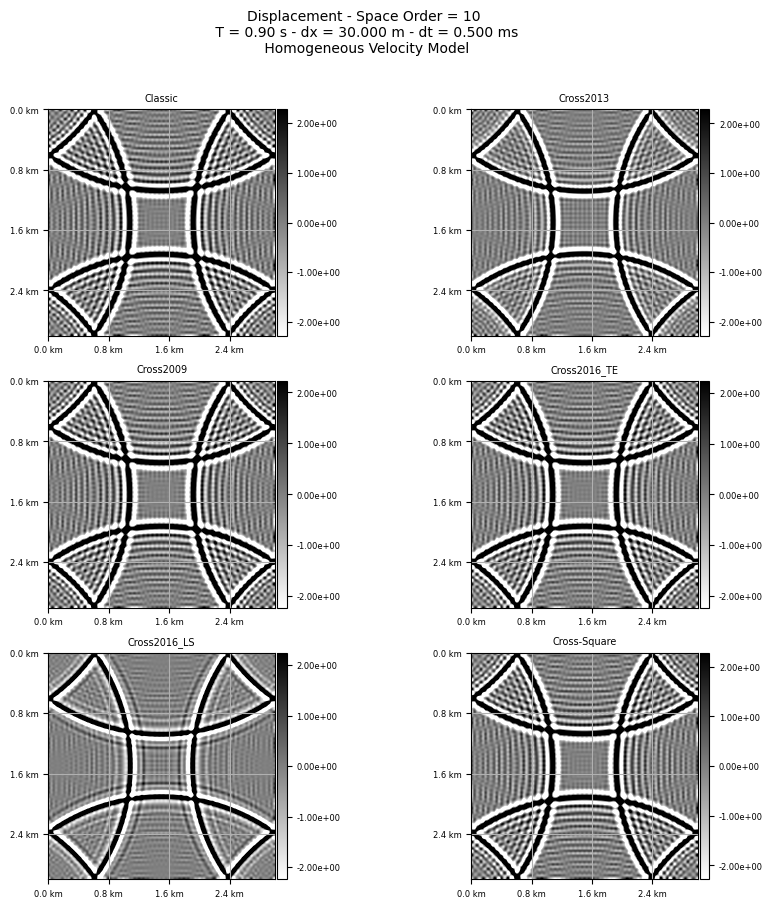

In [10]:
fscale     = 10**(-3)   
x0         = teste.x0
x1         = teste.x0 + teste.compx
y0         = teste.y0
y1         = teste.y0 + teste.compy
timevalue  = fscale*tn    

vtest_name = ['Homogeneous','Heterogeneous','SEG EAGE 2D Salt','Marmousi']
vnames     = ['Classic','Cross2013','Cross2009','Cross2016_TE','Cross2016_LS','Cross-Square']

if(ptype==1 or ptype==2): 
        
    factor     = 10
    aspect_def = 'equal'

else:
        
    factor     = 50
    aspect_def = 'auto'                
    
fig1 = plot.figure(figsize = (10,10))
   
plot.suptitle('Displacement - Space Order = %d \n T = %.2f s - dx = %.3f m - dt = %.3f ms \n %s Velocity Model '%(sou,timevalue,hxv,dt0,vtest_name[ptype-1]),fontsize=10)
 
grid = plot.GridSpec(3,2,wspace=0.2,hspace=0.2)

xpos = [0,0,1,1,2,2]
ypos = [0,1,0,1,0,1]

for kteste in range(0,ntestes):
    
    xposloc = xpos[kteste]
    yposloc = ypos[kteste]
    scale = np.amax(vresults[kteste])/factor
    plot.subplot(grid[xposloc,yposloc])           
    plot.title(vnames[kteste],fontsize=7)
    ax     = plot.gca()
    extent = [fscale*x0,fscale*x1, fscale*y1, fscale*y0]
    fig    = plot.imshow(np.transpose(vresults[kteste]),vmin=-scale,vmax=scale,cmap=cm.binary, extent=extent,interpolation='bicubic', aspect=aspect_def)
    plot.grid()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    ax.tick_params(axis="x", labelsize=6)
    ax.tick_params(axis="y", labelsize=6)
    plot.gca().xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f km'))
    plot.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f km'))
    ax.xaxis.set_major_locator(plot.MaxNLocator(4))
    ax.yaxis.set_major_locator(plot.MaxNLocator(4))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="4%", pad=0.025)
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar = plot.colorbar(fig, cax=cax, format='%.2e')
    cbar.ax.tick_params(labelsize=6)
    cbar.locator = tick_locator
    cbar.update_ticks()

plot.show()